# Inference and visualization for DiffAssemble


In [38]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns
import numpy as np
import imageio.v2 as imageio


from PIL import Image, ImageFile

In [35]:
from src.model.full_models import *
from src.full_dataset import *
from src.gnn_diffusion import GNN_Diffusion

### 0.- Define functions for visualization

#### 0.1.- Comparative images

In [36]:
# Visualize one denoising step in pose space: [x, y, rot_x, rot_y]
# (consistent with Puzzle_Dataset_ROT + GNN_Diffusion training objective)
def _plot_pose(ax, x_pose, title, cmap_name="tab10"):
    xy = x_pose[:, :2].detach().cpu()
    rot = x_pose[:, 2:4].detach().cpu()
    rot = torch.nn.functional.normalize(rot, dim=1, eps=1e-8)  # stable arrows

    n = xy.shape[0]
    cmap = plt.get_cmap(cmap_name, n)  # one distinct color per patch
    colors = cmap(np.arange(n))

    ax.scatter(xy[:, 0], xy[:, 1], s=18, alpha=0.9, c=colors)
    ax.quiver(
        xy[:, 0], xy[:, 1],
        rot[:, 0], rot[:, 1],
        color=colors,
        angles="xy", scale_units="xy", scale=6, width=0.004, alpha=0.8
    )
    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(1.15, -1.15)  # image-like orientation
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.grid(alpha=0.25)

In [85]:
def render_pose_exact(ax, patches, x_pose, title, half_w, half_h, unrotate_input_k=None):
    """
    patches: [N,C,H,W] tensor in [0,1]
    x_pose:  [N,4] -> (x,y,rx,ry), with x,y normalized coordinates
    unrotate_input_k: optional [N] int tensor (e.g. sample.rot_index) to undo dataset-applied discrete rotation first
    """
    xy = x_pose[:, :2].detach().cpu()
    rot = x_pose[:, 2:4].detach().cpu()
    patches = patches.detach().cpu().clamp(0, 1)

    if unrotate_input_k is not None:
        k = unrotate_input_k.detach().cpu().long()
        patches = torch.stack([torch.rot90(p, k=int((-kk.item()) % 4), dims=(1, 2)) for p, kk in zip(patches, k)])

    # exact continuous angle from (rx, ry)
    theta = torch.atan2(rot[:, 1], rot[:, 0]).numpy()  # radians

    valid = torch.isfinite(xy).all(dim=1) & torch.isfinite(torch.tensor(theta))
    xy = xy[valid]
    theta = theta[valid.numpy() if hasattr(valid, "numpy") else valid]
    patches = patches[valid]

    for i in range(patches.shape[0]):
        img = patches[i].permute(1, 2, 0).numpy()
        x, y = float(xy[i, 0]), float(xy[i, 1])

        im = ax.imshow(
            img,
            extent=[x - half_w, x + half_w, y - half_h, y + half_h],
            interpolation="nearest",
            origin="lower",
        )
        im.set_transform(transforms.Affine2D().rotate_around(x, y, float(theta[i])) + ax.transData)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(1.2, -1.2)
    ax.set_aspect("equal")
    ax.set_title(title, color="white")
    ax.axis("off")


def show_triptych_exact(patches, x_start, x_noisy, x0_hat, t=None, unrotate_input_k=None):
    # use clean grid spacing only for visual patch size
    xy0 = x_start[:, :2].detach().cpu()
    xs = torch.sort(torch.unique(xy0[:, 0]))[0]
    ys = torch.sort(torch.unique(xy0[:, 1]))[0]
    dx = float((xs[1] - xs[0]).item()) if len(xs) > 1 else 0.3
    dy = float((ys[1] - ys[0]).item()) if len(ys) > 1 else 0.3
    half_w, half_h = 0.48 * dx, 0.48 * dy

    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.patch.set_facecolor("black")


    render_pose_exact(axs[0], patches, x_start, "Clean x0", half_w, half_h, unrotate_input_k=unrotate_input_k)
    render_pose_exact(axs[1], patches, x_noisy, f"Noisy xt (t={t})" if t is not None else "Noisy xt", half_w, half_h, unrotate_input_k=unrotate_input_k)
    render_pose_exact(axs[2], patches, x0_hat, "Reconstructed x0_hat", half_w, half_h, unrotate_input_k=unrotate_input_k)
    plt.tight_layout()
    plt.savefig("outputs/denoise_triptych.png", dpi=600)
    plt.show()


#### 0.2.- Gif

In [39]:
def make_denoise_gif(x_start, x_noisy, x0_hat, t_value, out_path="outputs/denoise_timeline.gif"):
    os.makedirs("outputs", exist_ok=True)
    frames = []

    # Animation schedule
    hold_clean = 8
    to_noisy = 14
    hold_noisy = 8
    to_denoised = 14
    hold_denoised = 10

    def render_pose_to_frame(x_pose, title):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        _plot_pose(ax, x_pose, title)  # uses your existing helper from cell 15
        fig.tight_layout()
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
        plt.close(fig)
        return frame

    # 1) clean hold
    for _ in range(hold_clean):
        frames.append(render_pose_to_frame(x_start, "Clean x0"))

    # 2) clean -> noisy
    for a in np.linspace(0, 1, to_noisy):
        x_mid = (1 - a) * x_start + a * x_noisy
        frames.append(render_pose_to_frame(x_mid, f"Noising (t={t_value})"))

    # 3) noisy hold
    for _ in range(hold_noisy):
        frames.append(render_pose_to_frame(x_noisy, f"Noisy xt (t={t_value})"))

    # 4) noisy -> denoised
    for a in np.linspace(0, 1, to_denoised):
        x_mid = (1 - a) * x_noisy + a * x0_hat
        frames.append(render_pose_to_frame(x_mid, "Denoising"))

    # 5) denoised hold
    for _ in range(hold_denoised):
        frames.append(render_pose_to_frame(x0_hat, "Reconstructed x0_hat"))

    imageio.mimsave(out_path, frames, fps=8, loop=0)
    return out_path


In [40]:
def make_denoise_gif_with_patches(
    patches, x_start, x_noisy, x0_hat, t_value,
    out_path="outputs/denoise_patches.gif",
    unrotate_input_k=None
):
    os.makedirs("outputs", exist_ok=True)

    # Same sizing logic as your triptych
    xy0 = x_start[:, :2].detach().cpu()
    xs = torch.sort(torch.unique(xy0[:, 0]))[0]
    ys = torch.sort(torch.unique(xy0[:, 1]))[0]
    dx = float((xs[1] - xs[0]).item()) if len(xs) > 1 else 0.3
    dy = float((ys[1] - ys[0]).item()) if len(ys) > 1 else 0.3
    half_w, half_h = 0.48 * dx, 0.48 * dy

    frames = []
    hold_clean, to_noisy, hold_noisy, to_denoised, hold_denoised = 8, 14, 8, 14, 10

    def _render_frame(x_pose, title):
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        render_pose_exact(
            ax, patches, x_pose, title, half_w, half_h,
            unrotate_input_k=unrotate_input_k
        )
        fig.patch.set_facecolor("black")
        fig.tight_layout()
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
        plt.close(fig)
        return frame

    # 1) clean hold
    for _ in range(hold_clean):
        frames.append(_render_frame(x_start, "Clean x0"))

    # 2) clean -> noisy
    for a in np.linspace(0, 1, to_noisy):
        x_mid = (1 - a) * x_start + a * x_noisy
        frames.append(_render_frame(x_mid, f"Noising (t={t_value})"))

    # 3) noisy hold
    for _ in range(hold_noisy):
        frames.append(_render_frame(x_noisy, f"Noisy xt (t={t_value})"))

    # 4) noisy -> denoised
    for a in np.linspace(0, 1, to_denoised):
        x_mid = (1 - a) * x_noisy + a * x0_hat
        frames.append(_render_frame(x_mid, "Denoising"))

    # 5) denoised hold
    for _ in range(hold_denoised):
        frames.append(_render_frame(x0_hat, "Reconstructed x0_hat"))

    imageio.mimsave(out_path, frames, fps=8, loop=0)
    return out_path


### 0.- Define paths and steps

In [24]:
dataset_path = os.path.join(os.getcwd(), "data/CelebA-HQ")
print(dataset_path)

steps = 100

/home/mlmcri/Documentos/Courses/2025_2026_AI_course/deep-learning-puzzle-project/data/CelebA-HQ


### 1.- Load test dataset


Test dataset length: 5999
Sample image: 


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

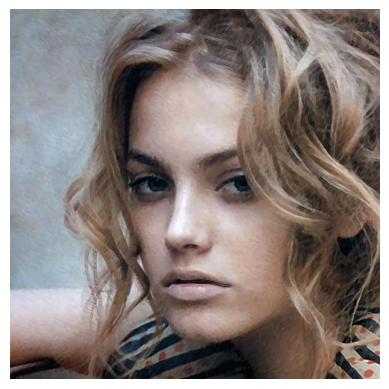

In [25]:
# Load base dataset
test_dataset_base = CelebA_HQ(dataset_path, train=False)
print(f"Test dataset length: {len(test_dataset_base)}")
print(f"Sample image: ")
plt.imshow(test_dataset_base[5812])
plt.axis("off")

In [26]:
# Load puzzle dataset and sample an element
test_puzzle_dt = Puzzle_Dataset(
                        dataset=test_dataset_base,
                        #dataset_get_fn=lambda x: x,
                        patch_per_dim=[(6,6)], 
                        augment=False, 
                        degree=-1, 
                        unique_graph=None)

elem = test_puzzle_dt[0]

print(elem)
print(f"X: {elem.x}") # This contains all the node features: x, y, rot1, rot2
print(f"EDGE_INDEX: {elem.edge_index}")
print(f"INDEXES: {elem.indexes}")
# print(f"ROT: {elem.rot}")
# print(f"ROT_INDEX: {elem.rot_index}")
print(f"IND_NAME: {elem.ind_name}")

Data(x=[36, 2], edge_index=[2, 1296], indexes=[36], patches=[36, 3, 32, 32], ind_name=[1], patches_dim=[1, 2])
X: tensor([[-1.0000, -1.0000],
        [-0.6000, -1.0000],
        [-0.2000, -1.0000],
        [ 0.2000, -1.0000],
        [ 0.6000, -1.0000],
        [ 1.0000, -1.0000],
        [-1.0000, -0.6000],
        [-0.6000, -0.6000],
        [-0.2000, -0.6000],
        [ 0.2000, -0.6000],
        [ 0.6000, -0.6000],
        [ 1.0000, -0.6000],
        [-1.0000, -0.2000],
        [-0.6000, -0.2000],
        [-0.2000, -0.2000],
        [ 0.2000, -0.2000],
        [ 0.6000, -0.2000],
        [ 1.0000, -0.2000],
        [-1.0000,  0.2000],
        [-0.6000,  0.2000],
        [-0.2000,  0.2000],
        [ 0.2000,  0.2000],
        [ 0.6000,  0.2000],
        [ 1.0000,  0.2000],
        [-1.0000,  0.6000],
        [-0.6000,  0.6000],
        [-0.2000,  0.6000],
        [ 0.2000,  0.6000],
        [ 0.6000,  0.6000],
        [ 1.0000,  0.6000],
        [-1.0000,  1.0000],
        [-0.6000, 

### Load model with the checkpoint from training

In [41]:
#Load model
model = Eff_GAT(steps=steps,
                input_channels=4,
                output_channels=4,
                n_layers=4,
                model="resnet18equiv",
                architecture="transformer")

# Load model with the checkpoint and set to evaluation mode
checkpoint = torch.load("checkpoints/model_epoch25.pt",
                        weights_only=False,
                        map_location=torch.device("cpu"))

# model.load_state_dict(checkpoint["model_state_dict"])
model.load_state_dict(checkpoint)
model.eval()

print("Model parameters after loading checkpoint:")
for name, param in model.named_parameters():
    print(name, param)


Model parameters after loading checkpoint:
visual_backbone.conv1.weight Parameter containing:
tensor([[[[[ 1.0918e-01, -1.2187e-01, -1.4525e-01],
           [-1.8236e-01, -6.8362e-02, -9.4002e-02],
           [-1.2981e-01, -9.1892e-02, -7.6550e-02]]],


         [[[-4.2245e-02, -7.3820e-02, -4.9891e-02],
           [-8.6846e-02,  8.8763e-02, -6.5765e-02],
           [ 1.9675e-02, -8.0747e-02, -3.5640e-02]]],


         [[[ 8.1142e-02,  1.0025e-01, -1.3930e-01],
           [ 1.5948e-01, -3.9776e-02,  1.7254e-01],
           [ 8.9041e-02,  1.9297e-01, -1.3025e-01]]]],



        [[[[ 6.9245e-02,  1.8131e-01, -7.8453e-02],
           [ 7.8074e-02, -1.3198e-01,  1.2166e-01],
           [-2.5202e-02, -1.5514e-01, -2.1918e-01]]],


         [[[-2.8541e-02,  1.2829e-01, -4.4170e-02],
           [ 1.5650e-02,  1.2571e-01, -1.8536e-02],
           [ 1.4519e-01, -9.9929e-03, -1.8626e-01]]],


         [[[-6.1202e-02, -6.4002e-02, -1.3131e-01],
           [ 2.0868e-01, -4.4018e-02, -5.2712e-05],


### Run inference with a single sample

In [80]:
# Dataloader
batch_size = 1
test_loader = torch_geometric.loader.DataLoader(test_puzzle_dt, 
                                                batch_size=batch_size, 
                                                shuffle=True)

# Get one batch
sample = next(iter(test_loader))

# Add/force "no rotation" feature [1, 0] for every node in the batch
N = sample.x.size(0)  # total nodes across all graphs in batch
rot = torch.zeros(N, 2, dtype=sample.x.dtype, device=sample.x.device)
rot[:, 0] = 1.0

if sample.x.size(1) == 2:
    sample.x = torch.cat([sample.x, rot], dim=1)   # [N,4]
else:
    sample.x[:, 2:4] = rot                        # overwrite existing rot channels

sample.rot = rot
sample.rot_index = torch.zeros(N, dtype=torch.long, device=sample.x.device)

print("x shape:", sample.x.shape)                 # [total_nodes, 4]
print("edge_index shape:", sample.edge_index.shape)
print("indexes shape:", sample.indexes.shape)
print("rot shape:", sample.rot.shape)
print("rot_index shape:", sample.rot_index.shape)
print("ind_name:", sample.ind_name)               # one per graph
print("batch vector shape:", sample.batch.shape)  # node -> graph id
print("num graphs:", int(sample.batch.max().item()) + 1)


x shape: torch.Size([36, 4])
edge_index shape: torch.Size([2, 1296])
indexes shape: torch.Size([36])
rot shape: torch.Size([36, 2])
rot_index shape: torch.Size([36])
ind_name: tensor([2256])
batch vector shape: torch.Size([36])
num graphs: 1


In [81]:
# Load criterion, inference GNN Diffusion class, and run inference step
criterion = torch.nn.functional.smooth_l1_loss
gnn_diffusion = GNN_Diffusion(steps=steps)

if not hasattr(sample, "batch") or sample.batch is None:
    sample.batch = torch.zeros(sample.x.size(0), dtype=torch.long, device=gnn_diffusion.device)

# Run inference step
with torch.no_grad():
    num_graphs = int(sample.batch.max().item()) + 1
    t_graph = torch.Tensor([range(gnn_diffusion.steps)[-1]], device=gnn_diffusion.device).long()
    t = torch.gather(t_graph, 0, sample.batch)

    x_start = sample.x
    noise = torch.randn_like(x_start)
    x_noisy = gnn_diffusion.q_sample(x_start=x_start, t=t, noise=noise)

    patch_feats = model.visual_features(sample.patches)
    pred_noise, _ = model.forward_with_feats(
        x_noisy, t, sample.patches, sample.edge_index, patch_feats, sample.batch
    )

    # Reconstruct denoised x0 estimate from epsilon prediction
    sqrt_ab = gnn_diffusion.sqrt_alphas_cumprod.to(gnn_diffusion.device)[t].unsqueeze(-1)
    sqrt_1mab = gnn_diffusion.sqrt_one_minus_alphas_cumprod.to(gnn_diffusion.device)[t].unsqueeze(-1)
    x0_hat = (x_noisy - sqrt_1mab * pred_noise) / (sqrt_ab + 1e-8)

    loss = torch.nn.functional.smooth_l1_loss(noise, pred_noise).item()

print(f"Sample loss: {loss}")


Sample loss: 0.017091238871216774


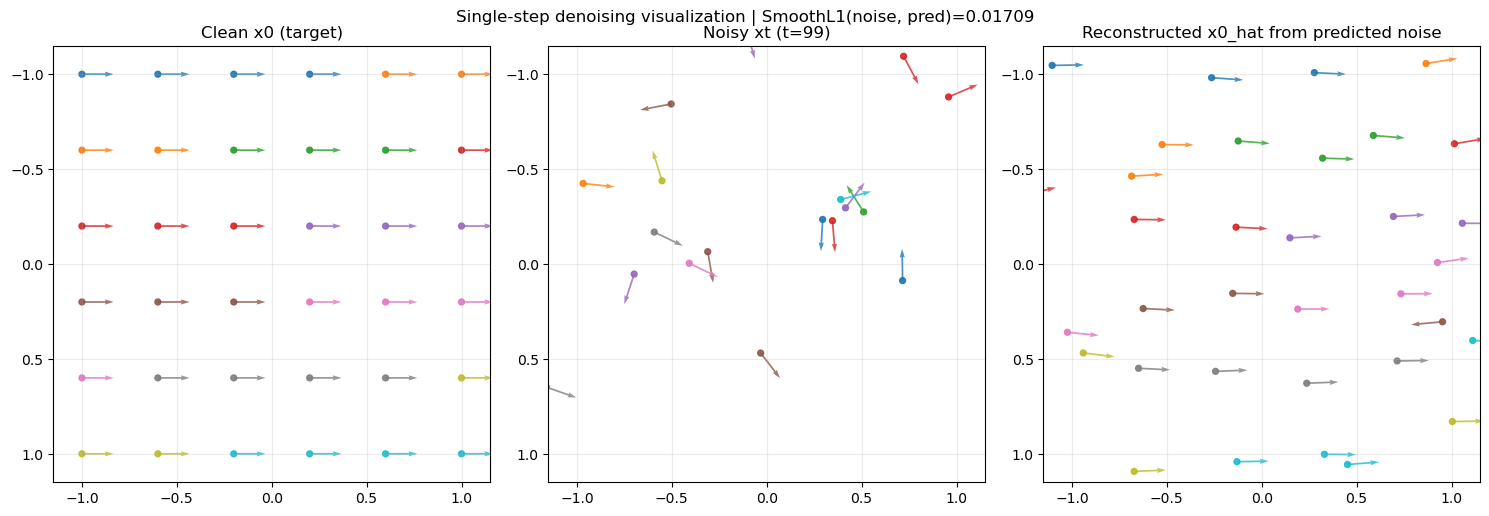

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
_plot_pose(axs[0], x_start, "Clean x0 (target)")
_plot_pose(axs[1], x_noisy, f"Noisy xt (t={int(t[0].item())})")
_plot_pose(axs[2], x0_hat, "Reconstructed x0_hat from predicted noise")
fig.suptitle(f"Single-step denoising visualization | SmoothL1(noise, pred)={loss:.5f}")
plt.tight_layout()
plt.savefig("outputs/denoise_arrows.png", dpi=600)
plt.show()


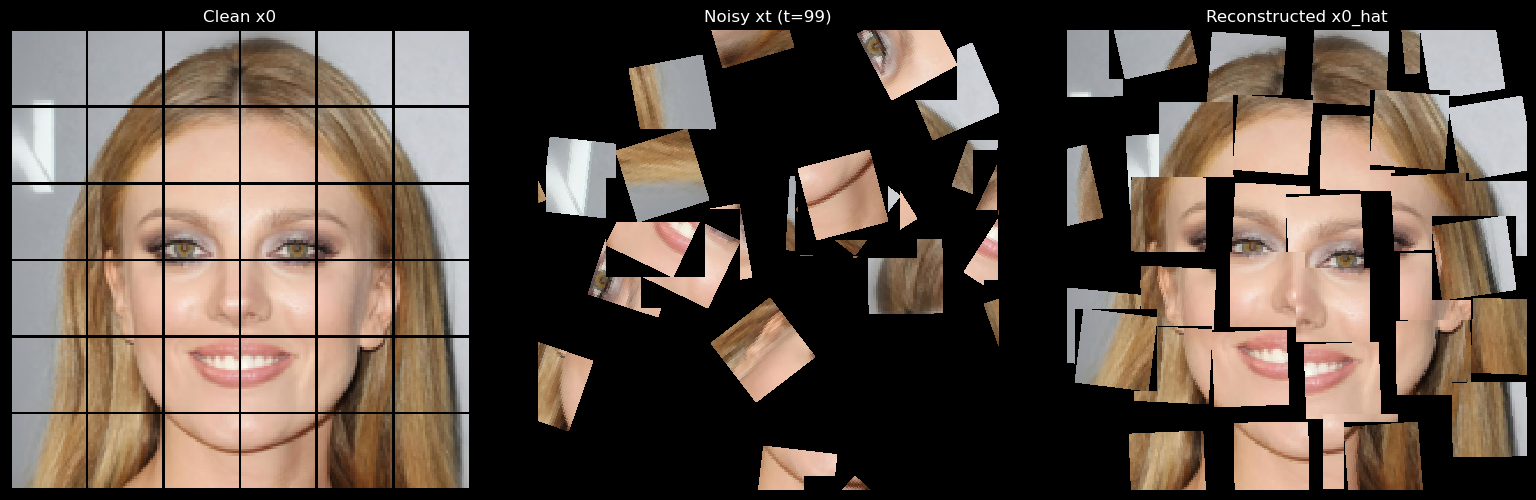

In [87]:
show_triptych_exact(
    sample.patches, x_start, x_noisy, x0_hat,
    t=int(t[0].item()),
    unrotate_input_k=None  # set to None if not using Puzzle_Dataset_ROT
)


### Animation?

In [88]:
gif_path = make_denoise_gif(
    x_start.detach().cpu(),
    x_noisy.detach().cpu(),
    x0_hat.detach().cpu(),
    t_value=int(t[0].item()),
)
print("Saved:", gif_path)
gif_path = make_denoise_gif_with_patches(
    patches=sample.patches.detach().cpu(),
    x_start=x_start.detach().cpu(),
    x_noisy=x_noisy.detach().cpu(),
    x0_hat=x0_hat.detach().cpu(),
    t_value=int(t[0].item()),
    # unrotate_input_k=sample_viz.rot_index.detach().cpu()  # optional
)
print("Saved:", gif_path)


Saved: outputs/denoise_timeline.gif
Saved: outputs/denoise_patches.gif
